## 생각해볼거

lg 불편 감지 여러가지 시도


k fold

데이터 증강

양방향 lstm

## LSTM dacon

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from google.colab import drive

drive.mount('/content/drive')

import datetime as dt

PATH = '/content/drive/My Drive/Colab Notebooks/data/동작분류/open/'

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
plt.style.use('ggplot') # default plot style.

from scipy import stats
from scipy.stats import norm

import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from tqdm import tqdm
from fastprogress import master_bar, progress_bar



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F



import math
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
train=pd.read_csv(PATH+'train_features.csv')
train_labels=pd.read_csv(PATH+'train_labels.csv')
test=pd.read_csv(PATH+'test_features.csv')
submission=pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
display(train.describe())
display(test.describe())

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06
mean,1.562000e+03,2.995000e+02,-4.489683e-01,-1.617913e-01,5.571471e-02,-1.307982e+00,-4.337745e-01,8.864100e-01
std,9.021100e+02,1.732049e+02,7.173082e-01,5.872018e-01,4.724824e-01,6.083228e+01,7.329832e+01,7.063345e+01
min,0.000000e+00,0.000000e+00,-8.838427e+00,-9.299714e+00,-8.316425e+00,-1.811127e+03,-1.594256e+03,-1.346143e+03
25%,7.810000e+02,1.497500e+02,-9.625643e-01,-5.163020e-01,-2.123550e-01,-2.048984e+01,-1.865320e+01,-1.546226e+01
50%,1.562000e+03,2.995000e+02,-6.560482e-01,-2.033985e-01,3.031258e-02,-1.421819e+00,-2.642753e-01,-1.798643e-01
75%,2.343000e+03,4.492500e+02,-1.701162e-04,1.406493e-01,3.581982e-01,1.572245e+01,1.676328e+01,1.641878e+01
max,3.124000e+03,5.990000e+02,8.426799e+00,8.484622e+00,6.432668e+00,1.870256e+03,2.111657e+03,1.255849e+03


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,469200.000000,469200.000000,469200.000000,469200.000000,469200.000000,469200.000000,469200.000000,469200.000000
mean,3515.500000,299.500000,-0.450305,-0.188638,0.047377,-1.368040,-0.886681,0.524323
std,225.744011,173.205025,0.719705,0.572534,0.473548,63.273916,72.960652,70.565590
min,3125.000000,0.000000,-8.339774,-8.016826,-7.167801,-1148.067436,-1328.322686,-1288.723399
25%,3320.000000,149.750000,-0.966716,-0.533114,-0.212799,-20.988234,-19.548521,-15.295959
50%,3515.500000,299.500000,-0.659828,-0.227487,0.011947,-1.407126,-0.221448,-0.422151
75%,3711.000000,449.250000,-0.005081,0.117209,0.347686,15.552447,16.800463,15.370501
max,3906.000000,599.000000,8.173537,6.398895,7.517018,1260.580296,1761.286813,1066.225136


In [ ]:
print(len(train_labels))

3125


##undersamplinig

In [ ]:
# # 26 너무많아서 undersampling
# train=pd.read_csv(PATH+'train_features.csv')
# train_labels=pd.read_csv(PATH+'train_labels.csv')

# temp = train_labels.loc[train_labels['label'] == 26]['id'][:1400].values
# train = train.loc[~train['id'].isin(temp),:]
# train_labels=train_labels.loc[~train_labels['id'].isin(temp),:]

In [ ]:
 train.loc[~train['id'].isin(temp),:]

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


## 데이터 증강

In [ ]:
display(train)
display(train_labels)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [ ]:
temp = train["acc_x"] + train["acc_y"]
train['acc_x+acc_y'] = temp

In [ ]:
temp = test["acc_x"] + test["acc_y"]
test['acc_x+acc_y'] = temp

In [ ]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_x+acc_y
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.026715
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.088723
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.109495
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.062729
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.113130
...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,-1.370887
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,-1.341503
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,-1.331355
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,-1.313098


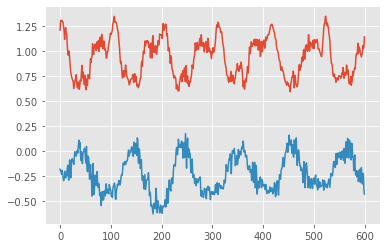

In [ ]:
plt.plot(train.iloc[:600,2])
plt.plot(train.iloc[:600,3])

In [ ]:
# temp = train
# lst = list(temp)
# lst[2], lst[3] = lst[3], lst[2]
# temp.columns = lst

In [ ]:
temp = y.tolist()
for i in set(temp):
  print(f'{i} : {temp.count(i)} \t')

## 정규화

In [ ]:
# # normalization_df = (df - df.mean())/df.std()
# # normalization_df.head()
# df=train.iloc[:,2:]
# normalization_df = (df - df.mean())/df.std()
# # train.iloc[:,2:] = normalization_df

In [ ]:
# display(train.iloc[:,2:])
# display(normalization_df)

train test 같은 scaler로 해야된다 실수 ㄴㄴ

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform( train.iloc[:,2:] ))
test_scaled = pd.DataFrame(scaler.transform( test.iloc[:,2:] ))

In [ ]:
# sns.boxplot(pd.DataFrame(train_X).iloc[:,0])

## variable

In [ ]:
len(train_scaled.columns)

6

In [ ]:
X = train_scaled.values.reshape(-1,600,len(train_scaled.columns))
# y = tf.keras.utils.to_categorical(train_labels['label']) 
y = train_labels['label'].values 
test  = test_scaled.values.reshape(-1,600,len(test_scaled.columns))


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train = (torch.Tensor(X_train))
X_test = (torch.Tensor(X_test))
y_train = (torch.Tensor(y_train))
y_test = (torch.Tensor(y_test))
test = (torch.Tensor(test))

In [ ]:
temp = y_train.tolist()
for i in set(temp):
  print(f'{i} : {temp.count(i)}')
  

0.0 : 10
1.0 : 21
2.0 : 15
3.0 : 23
4.0 : 30
5.0 : 23
6.0 : 21
7.0 : 23
8.0 : 88
9.0 : 36
10.0 : 18
11.0 : 20
12.0 : 9
13.0 : 11
14.0 : 24
15.0 : 25
16.0 : 20
17.0 : 24
18.0 : 43
19.0 : 18
20.0 : 23
21.0 : 23
22.0 : 18
23.0 : 15
24.0 : 31
25.0 : 19
26.0 : 1376
27.0 : 32
28.0 : 47
29.0 : 17
30.0 : 31
31.0 : 19
32.0 : 18
33.0 : 20
34.0 : 19
35.0 : 28
36.0 : 23
37.0 : 34
38.0 : 16
39.0 : 20
40.0 : 32
41.0 : 18
42.0 : 18
43.0 : 30
44.0 : 18
45.0 : 20
46.0 : 17
47.0 : 22
48.0 : 20
49.0 : 27
50.0 : 32
51.0 : 23
52.0 : 11
53.0 : 11
54.0 : 20
55.0 : 33
56.0 : 34
57.0 : 17
58.0 : 17
59.0 : 19
60.0 : 42


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train,y_train) # create your datset
test_dataset = TensorDataset(X_test,y_test) # create your datset

train_dataloader = DataLoader(train_dataset,batch_size= 128,shuffle= True) # create your dataloader
valid_dataloader = DataLoader(test_dataset, batch_size =len(X_test) ) # create your dataloader


## early stopping

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            pass
            # print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## MODEL

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([2812, 600, 6])
torch.Size([313, 600, 6])
torch.Size([2812])
torch.Size([313])


In [ ]:
## many to many 로 구현해보자
# batch, seq, inputsize
# input [2812, 600, 6]
# output [2812]

#input of shape (seq_len, batch, input_size)

device = 'cuda:0'

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #self.seq_length = seq_length
        
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers,batch_first=True)
        
  
        self.fc1 = nn.Linear(hidden_size,1024)
        self.bn1 = nn.BatchNorm1d(1024,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(1024, 256)
            
        self.bn2 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.6)
        self.fc3= nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.softMax = nn.LogSoftmax(dim = 1)


        self.fc= nn.Linear(hidden_size, num_classes)

        # 지금 형태는 맨마지믁 lstm에서 마지막 layer의 hidden size 만 가져와서 그대로 fc로 보내는거임

    def forward(self, x):
        # print(f'x.size(0) : {x.size(0)}') #981
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        # 2, 981, 512
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        # self.count += 1
        # print(self.count)


        out1, (hn, cn) = self.LSTM(x, (h_1, c_1))
        #out1: batch_size, seq, hidden_size
        # torch.Size([batch, seq, hidden])
        #  1 print(out1[-1,-1,:])

        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]        # train

        # hidden state shpe is: torch.Size([2, batch, hidden])
        # final state shape is: torch.Size([981, 512])
        # output size : torch.Size([981, 96])
        # valid
        # hidden state shpe is: torch.Size([2, 110, 512])
        # final state shape is: torch.Size([110, 512])
        # torch.Size([110, 96])
        
        # print("hidden state shpe is:",hn.size())
        # y = hn.view(-1, self.hidden_size)
        # final_1_state = out1[:,-2,:]
        
  
        # 2 print(out1[-1,-1,:]) 1 == 2
        # print(final_state[1:10,:10])

        # print("final state shape is:",final_state.shape)

        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)

        # out = self.fc(final_state)

        return out



    
 

## train

In [ ]:
device = 'cuda'
SAVEPATH = '/content/drive/My Drive/Colab Notebooks/대회/dacon 동작분류/'

patience = 100

# early_stopping = EarlyStopping(patience = patience, verbose = True)

num_epochs = 500
learning_rate = 1e-3
input_size = 6
hidden_size = 512
num_layers = 2
num_classes = 61


train_losses = []
valid_losses = []


lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

# lstm.apply(init_weights)

criterion = torch.nn.CrossEntropyLoss()   # mean-squared error for regression
criterion = criterion.cuda()
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay= 1e-4)
# optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate,weight_decay=0.01)
optimizer = torch.optim.Adadelta(lstm.parameters())
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate,momentum=0.9)
# optimizer = torch.optim.RMSprop(lstm.parameters(), lr=learning_rate)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, mode='min', factor=0.1, verbose=True, min_lr=1e-7)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience= 30, 
#           factor =0.1 ,min_lr=1e-6, eps=1e-08)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[35,55,70,150], gamma=0.1)



for epoch in progress_bar(range(num_epochs+1)): 


  #########################################################################################################
  # train
  losses = []
  for i, (input, target) in enumerate(train_dataloader):

    lstm.train()
    outputs = lstm(input.to(device))
    optimizer.zero_grad()

    loss = criterion(outputs, target.type(torch.long).to(device))
    loss.backward()

    # torch.nn.utils.clip_grad_norm_(lstm.parameters(), 3)

    optimizer.step()
    losses.append(loss.item())

  train_losses.append(np.mean(np.array(losses)))
  # scheduler.step()

  losses = []

  #########################################################################################################
  #Valid
  for i, (input, target) in enumerate(valid_dataloader):
    lstm.eval()
    with torch.no_grad():
      valid = lstm(input.to(device))

      #inverse
      # valid = torch.from_numpy(scaler.inverse_transform(valid.cpu().detach().numpy()))

      vall_loss = criterion(valid, target.type(torch.long).to(device))
      
      scheduler.step(vall_loss.item())
      losses.append(vall_loss.item())

        #accuracy
      if epoch % 1 == 0:
        # class_correct = list(0. for i in range(61))
        # class_total = list(0. for i in range(61))
        outputs = valid.cpu()
        labels = target

        _,predicted = torch.max(outputs,1)
        temp = [predicted,labels]

        c = (predicted == labels).squeeze()
        print(f' accuracy : {100 * c.tolist().count(True)/len(target)}') 
        ##개별 accuracy
        # for i in range(61):
        #   label = labels[i]
        #   class_correct[int(label)] += c[i].item()
        #   class_total[int(label)] += 1
        # for i in range(61):
        #   pass
          # print(f'label({i}) accuracy : {100 * class_correct[i] / class_total[i] if class_total[i]!= 0 else -1}')

    
  valid_losses.append(np.mean(np.array(losses)))


  # scheduler.step()

  if epoch % 1 == 0:
    # torch.save(lstm.state_dict(), SAVEPATH+'model_weight.pth')
    print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
                                                                    optimizer.param_groups[0]["lr"]))



  # # model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

  # # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
  # #   만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
  # early_stopping(round(valid_losses[-1],5), lstm)

  # if early_stopping.early_stop:
  #   print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
  #                                                                 optimizer.param_groups[0]["lr"]))
  #   torch.save(lstm.state_dict(), SAVEPATH+'model_weight.pth')

  #   break



 accuracy : 45.36741214057508
Epoch: 0, loss: 2.96229 valid loss:  3.08856 lr: 1.00000 
 accuracy : 45.36741214057508
Epoch: 1, loss: 2.48611 valid loss:  2.72452 lr: 1.00000 
 accuracy : 44.40894568690096
Epoch: 2, loss: 2.40312 valid loss:  2.44599 lr: 1.00000 
 accuracy : 46.325878594249204
Epoch: 3, loss: 2.31221 valid loss:  2.47555 lr: 1.00000 
 accuracy : 47.6038338658147
Epoch: 4, loss: 2.26081 valid loss:  2.41599 lr: 1.00000 
 accuracy : 46.00638977635783
Epoch: 5, loss: 2.22268 valid loss:  2.37572 lr: 1.00000 
 accuracy : 46.96485623003195
Epoch: 6, loss: 2.17896 valid loss:  2.39928 lr: 1.00000 
 accuracy : 46.96485623003195
Epoch: 7, loss: 2.17447 valid loss:  2.38542 lr: 1.00000 
 accuracy : 45.36741214057508
Epoch: 8, loss: 2.16478 valid loss:  2.37250 lr: 1.00000 
 accuracy : 46.64536741214057
Epoch: 9, loss: 2.13744 valid loss:  2.31351 lr: 1.00000 
 accuracy : 48.242811501597444
Epoch: 10, loss: 2.09212 valid loss:  2.34766 lr: 1.00000 
 accuracy : 46.64536741214057


KeyboardInterrupt: ignored


### 생각해볼거

k fold

데이터 증강

양방향 lstm

gru

## outputs

adamw가 최고인거같다. data다 때려박으면 1.01정도 나옴 (batch 128) init x

배치 32는 별로 안좋은듯 

그냥 512돌리면

Epoch: 270, loss: 0.05182 valid loss:  1.41103 lr: 0.00000 

weight_decay=0.1 하면  valid loss:  1.02 까지도 나옴

0.5하면 0.92??

1해도 뭐 엄청큰 별 차이없는듯

복잡하게안하고 그냥 fc하나만해도 비슷하게나옴


Epoch: 291, loss: 0.12142 valid loss:  1.20945 lr: 0.00000 

제출하면 1.04 나온다 acc 70임 



bidirection으로 layer 1 하면 1.9



In [ ]:
temp.tolist().count(False)

AttributeError: ignored

In [ ]:
## accuray 만들기
temp = []

lstm = LSTM2(61, 6, 200, 2)
lstm.to(device)
for i, (input, target) in enumerate(valid_dataloader):
    valid = lstm(input.to(device))
    class_correct = list(0. for i in range(61))
    class_total = list(0. for i in range(61))
    outputs = valid.cpu()
    labels = target
    _,predicted = torch.max(outputs,1)
    print(predicted)
    temp = [predicted,labels]

    c = (predicted == labels).squeeze()
    for i in range(61):
      label = labels[i]
      class_correct[int(label)] += c[i].item()
      class_total[int(label)] += 1
    for i in range(61):
      print(f'label({i}) accuracy : {100 * class_correct[i] / class_total[i] if class_total[i]!= 0 else -1}')

In [ ]:
temp[0]
# c = (predicted == labels).squeeze()

logsoftmax랑 nllloss 과정 찍어서 보자

In [ ]:
n = nn.LogSoftmax()
m = nn.Softmax()
s = nn.Sigmoid()
temp = torch.Tensor([0.2,0.2,2])
print("softmax : ",m(temp))
print("sigmoid : ",s(temp))
print("LogSoftmax : ",n(temp))
print("LogSoftmax : ",m(n(temp)))

softmax :  tensor([0.1242, 0.1242, 0.7515])
sigmoid :  tensor([0.5498, 0.5498, 0.8808])
LogSoftmax :  tensor([-2.0856, -2.0856, -0.2856])
LogSoftmax :  tensor([0.1242, 0.1242, 0.7515])


In [ ]:
>>> m = nn.LogSoftmax(dim=1)
>>> loss = nn.NLLLoss()
>>> # input is of size N x C = 3 x 5
>>> input = torch.randn(3, 5, requires_grad=True)
>>> # each element in target has to have 0 <= value < C
>>> target = torch.tensor([1, 0, 4])
>>> output = loss(m(input), target)
>>>

In [ ]:
input

## submission

In [ ]:
test.shape


torch.Size([782, 600, 6])

In [ ]:
for param_tensor in lstm.state_dict():
    print(param_tensor, "\t", lstm.state_dict()[param_tensor])


softmax 넣어서 submission만들기

In [ ]:
outputs = lstm(test.to('cuda'))
m = nn.Softmax(dim=1)
submission_softmax = m(outputs)

In [ ]:
submission_softmax

tensor([[1.7202e-06, 3.8681e-11, 3.0441e-08,  ..., 1.4519e-03, 3.7441e-10,
         2.4563e-06],
        [1.2672e-04, 1.4767e-08, 1.2941e-07,  ..., 3.3949e-09, 2.2857e-08,
         1.2725e-06],
        [8.2924e-06, 3.9650e-02, 3.4237e-07,  ..., 1.8372e-10, 4.4273e-05,
         7.6242e-07],
        ...,
        [1.6637e-04, 1.0576e-07, 2.9675e-07,  ..., 2.7917e-08, 6.3267e-07,
         7.4274e-06],
        [1.6089e-08, 1.7412e-05, 1.4453e-04,  ..., 3.9264e-12, 4.0513e-05,
         5.0389e-10],
        [3.7878e-05, 8.1278e-09, 3.0761e-07,  ..., 4.8442e-08, 1.5449e-07,
         3.3977e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
_,predict = torch.max(submission_softmax,1)
print(predict)
print(predict.shape)

tensor([ 9, 26, 45, 26, 26, 26, 26, 33,  8,  6, 42, 28, 43, 26, 26, 26, 18, 26,
         8, 60,  2, 33, 17, 30, 26, 26, 60, 26, 26, 26, 26, 11, 28, 26, 18, 26,
        28,  9, 26, 26, 23, 26, 26, 34, 26, 26, 38, 26, 56, 26, 26, 26, 26, 60,
        47, 26, 26, 26, 46, 26, 26, 25, 45, 26, 26,  8, 48, 51, 56, 26, 26, 26,
        26, 26, 26, 34,  7, 14, 60, 44, 26, 43, 26, 26,  8, 59, 24, 26, 21, 26,
        60, 46, 34, 26, 34, 21, 16,  9, 26, 26,  7, 60, 26, 55, 18,  8, 52, 35,
        26, 58, 60, 27, 25, 26, 26,  2, 26, 26, 26, 43, 26, 26, 26, 52, 30,  8,
        36,  8, 24,  8, 26, 12, 26, 36, 26, 26, 26, 27, 39, 11, 56, 30, 11, 25,
         8, 26, 10, 16, 19, 26, 26, 26, 26, 60, 26, 26, 26, 26, 26, 28, 26, 26,
        24, 26, 34, 23, 26, 24, 21, 26, 26, 18, 26, 54, 26, 25, 35, 26, 26,  5,
        26, 26, 26, 27,  3, 26, 26, 26, 26, 40, 35, 20, 26,  4, 26, 26, 28, 60,
        20,  5, 26, 18, 18, 26, 26, 26, 26, 25, 29, 40, 33, 60, 26, 26, 26, 26,
        26, 26, 26, 42, 43, 26,  5, 44, 

In [ ]:

from google.colab import files
submission.iloc[:,1:] = submission_softmax.cpu().detach().numpy()
submission.to_csv('example.csv',index=False) 
files.download('example.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
>>> m = nn.Softmax(dim=1)
>>> loss = nn.NLLLoss()
>>> # input is of size N x C = 3 x 5
>>> input = torch.tensor([[8,-11,2,3,4,5,6,7]]).float()
>>> input = m(input)
print(input)
>>> # each element in target has to have 0 <= value < C

# for i in range(8):
#   output = loss((input),  torch.tensor([i]))
#   print(output)
output = loss((input),  torch.tensor([0]))
print(output)


In [ ]:
torch.sum(input)

In [ ]:
>>> # input is of size N x C = 3 x 5
>>> input = torch.tensor([[1, 1, 1]]).float()
>>> input = m(input)
print(input.exp())